In [ ]:
# sudo apt install texlive-full

In [1]:
#beam_path = "/home/linux2/Downloads/Farfield/farfield_finite/140mm_ground"            
#beam_path = "/home/ankit/sky_sim_files_data"

#PATH = '/home/linux2/Downloads/msfitcodes/'
PATH = '/home/ankit/sky_sim_files_data'

#datafile_path = "/home/linux2/Downloads/Farfield/farfield_finite/140mm_ground/residues_final.txt"
datafile_path = "/home/ankit/sky_sim_files_data/Theory/residues_final.txt"

#sky_map_path = "."
sky_map_path = "/home/ankit/sky_sim_files_data/sky_model"

#recomb_path = "."
recomb_path = "/home/ankit/sky_sim_files_data/Theory"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib.colors as mcolors
matplotlib.rc('font', **font)

from scipy.signal import correlate
from scipy.optimize import curve_fit
from numpy.fft import fft, fftfreq, ifft
import scipy.optimize as opt

In [ ]:
from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u
import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, RegularGridInterpolator
import math
import ephem
import os
import healpy as hp

In [2]:
T_CMB = 2.72548             # CMB temperature
alpha = 2.5                 # decay factor 
h = 6.62607157e-34          # planck constant 
k = 1.3806488e-23           # Boltzmann constant
c = 2.99792458e+08          # speed of light
T_nu0 = 100      
nu0 = 0.150

In [3]:
# Recombination data

data = np.loadtxt('total_spec_new.txt') 
freq = []     # frequency
B = []        # radiance
for i in range(len(data)):
    freq.append(data[i][0])
    B.append(data[i][1])

# Extracting 2 GHz to 4 GHz signal

In [4]:
freq_24 = []

for val in freq:
    if val >= 2 and val <= 4:
        freq_24.append(val)

# Extracting B for 2 GHz to 4 GHz signal

In [5]:
index_start = freq.index(freq_24[0])                  # index of start of 2 GHz
index_end = freq.index(freq_24[-1])                   # index of end of 4 GHz

B_24 = B[index_start:index_end+1]


# Recombination temperature from Raylegh Jeans 

$B_\nu(T) = \frac{2h\nu}{c^2}\frac{\nu^3}{e^{\frac{h\nu}{k_BT}}-1}$   (Planck's Blackbody Radiation Function)

$\frac{h\nu}{K_BT} <<< 1$

$e^{\frac{h\nu}{k_BT}} = 1 + \frac{h\nu}{K_BT}$

$B_\nu(T) = \frac{2\nu^2k_BT}{c^2}$    (Rayleigh-Jeans Blackbody Radiation Function)

$T = \frac{Bc^2}{2K_B\nu^2}$ 




In [6]:
T_recomb = []    # Recombination temperature in 2 GHz to 4 GHz

for i in range(len(freq_24)):
        T_recomb.append((B_24[i]*(c**2))/(2*k*((freq_24[i]*1e+9)**2)))

# Power Law

$T_{pl} = 100(\frac{\nu}{\nu_0})^{-\alpha}$

In [7]:
T_pl = []
for val in freq_24:
    T_pl.append(T_nu0*((val/nu0)**(-alpha)))

# Generate Systematics
$T_{sys} = T_0sin(\frac{2\pi\nu}{\nu_0} + \phi ) $

In [8]:
freq_0 = 2       # Bandwidth GHz
T0_1 = 1         # Initial Amplitude
T0_2 = 0.5       # Initial Amplitude
Phi = 30         # Phase
omg = 5          # Omega

Tsys_1 = []
Tsys_2 = []
for val in freq_24:
    Tsys_1.append(T0_1*np.sin(omg*2*np.pi*val/freq_0 + np.pi*Phi/180))
    Tsys_2.append(T0_2*np.sin(omg*2*np.pi*val/freq_0 + np.pi*Phi/180))

# Total Temperature

In [9]:
T_total = []

for i in range(len(freq_24)):
        T_total.append((T_pl[i] + T_recomb[i] + Tsys_1[i] + T_CMB)*Tsys_2[i])

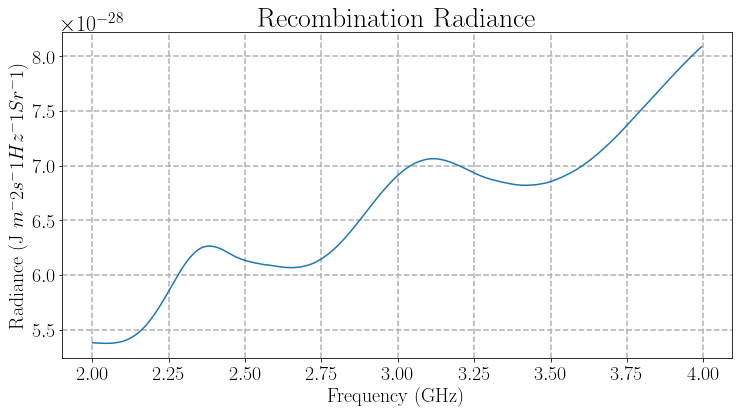

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, B_24)
plt.title('Recombination Radiance',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Radiance (J $m^-2 s^-1 Hz^-1 Sr^-1)$',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

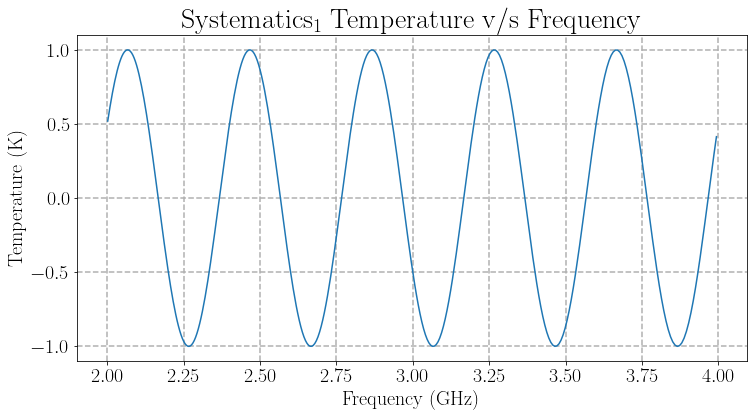

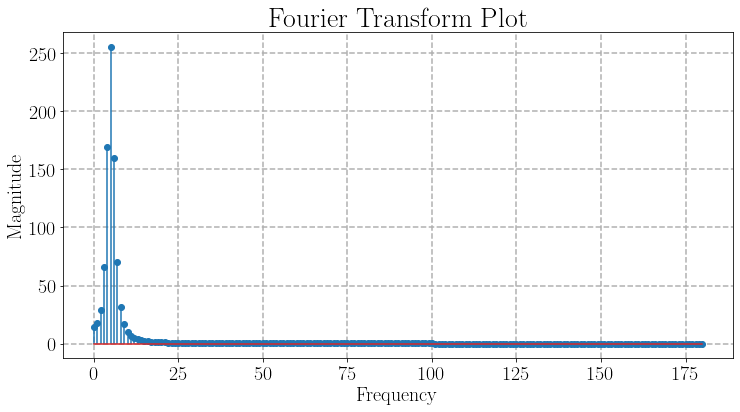

361
(array([5]),)
[0.01385042]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[5.]


In [11]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, Tsys_1)
plt.title('Systematics$_1$ Temperature v/s Frequency ',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

N = len(Tsys_1)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(Tsys_1)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(Tsys_1))

Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

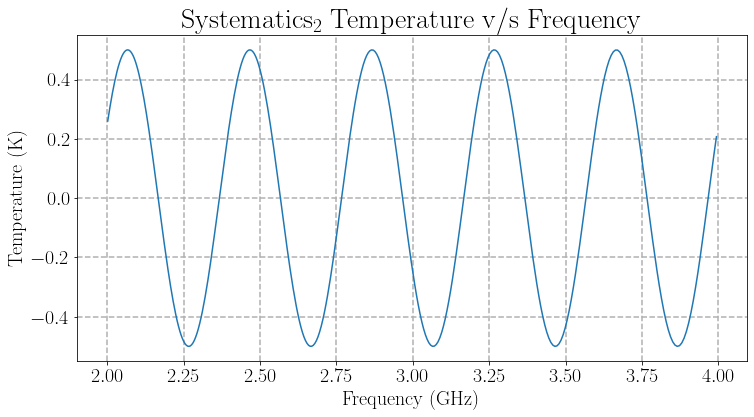

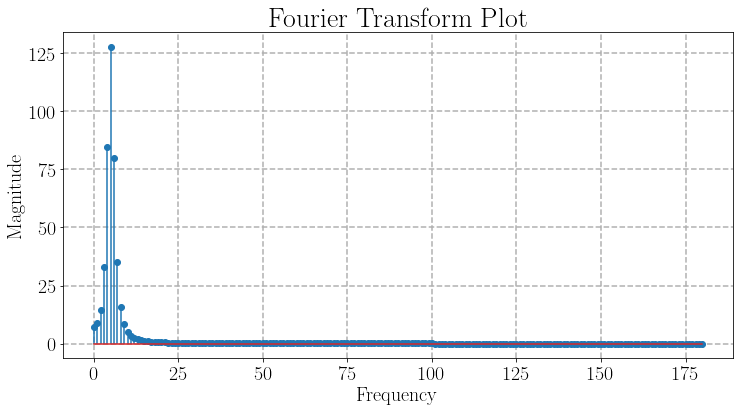

361
(array([5]),)
[0.01385042]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[5.]


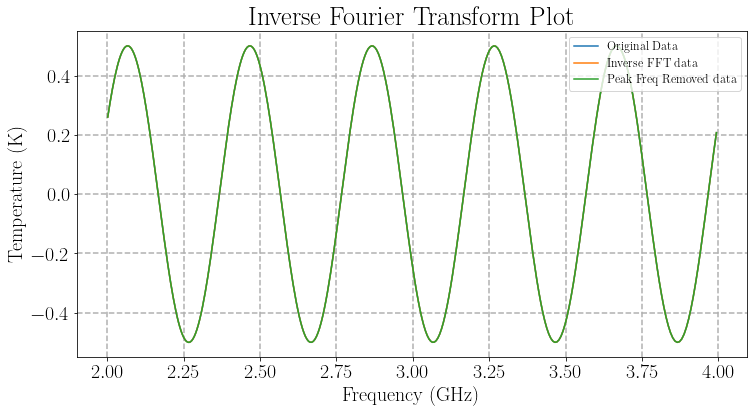

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, Tsys_2)
plt.title('Systematics$_2$ Temperature v/s Frequency ',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

N = len(Tsys_2)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(Tsys_2)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(Tsys_2))

Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

Nwaves = []
for val in Freqs:
    Nwaves.append(round(N*val))

FFT_new = np.copy(FFT_vals)
IFFT_data = np.real(ifft(FFT_vals))
Filt_data = np.real(ifft(FFT_new))

plt.figure(figsize=(12, 6))
plt.plot(freq_24, Tsys_2, label = 'Original Data')
plt.plot(freq_24, IFFT_data, label = 'Inverse FFT data')
plt.plot(freq_24, Filt_data, label = 'Peak Freq Removed data')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.title('Inverse Fourier Transform Plot')
plt.legend(loc = 'upper right', fontsize = 12)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()


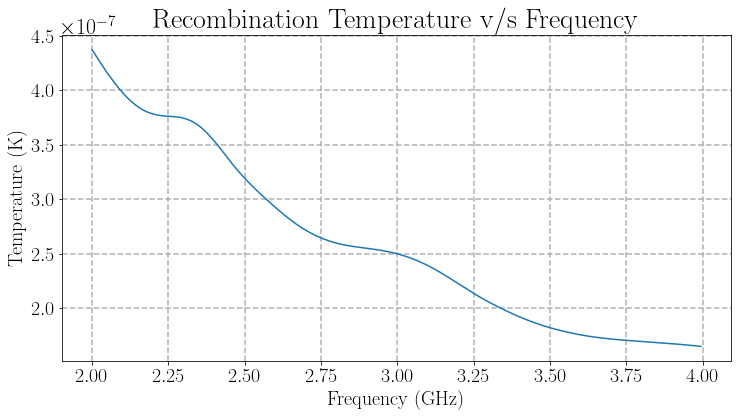

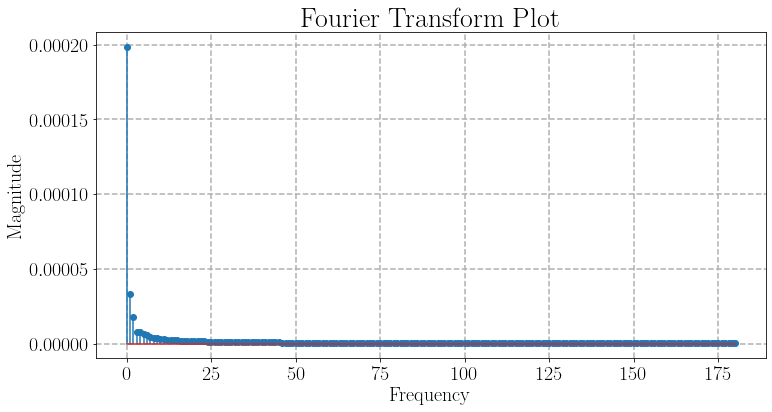

361
(array([0]),)
[0.]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[0.]


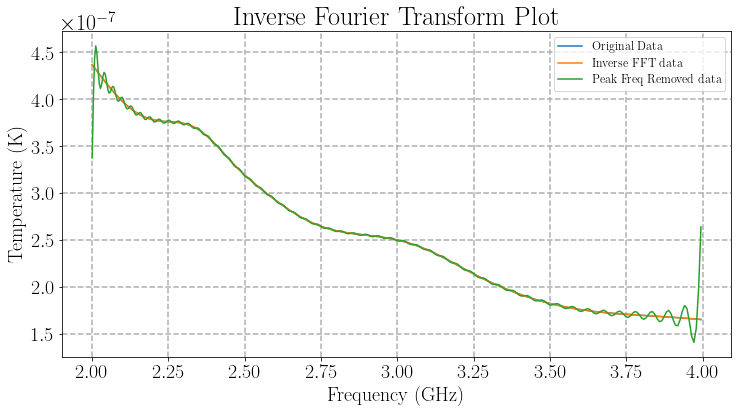

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_recomb)
plt.title('Recombination Temperature v/s Frequency',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20,  fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

N = len(T_recomb)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_recomb)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]


plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(T_recomb))
Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

Nwaves = []
for val in Freqs:
    Nwaves.append(round(N*val))


FFT_new = np.copy(FFT_vals)

for i in range(50,181):
    FFT_new[np.abs(Nwaves) == i] = 0.0
    
IFFT_data = np.real(ifft(FFT_vals))
Filt_data = np.real(ifft(FFT_new))

plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_recomb, label = 'Original Data')
plt.plot(freq_24, IFFT_data, label = 'Inverse FFT data')
plt.plot(freq_24, Filt_data, label = 'Peak Freq Removed data')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.title('Inverse Fourier Transform Plot')
plt.legend(loc = 'upper right', fontsize = 12)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

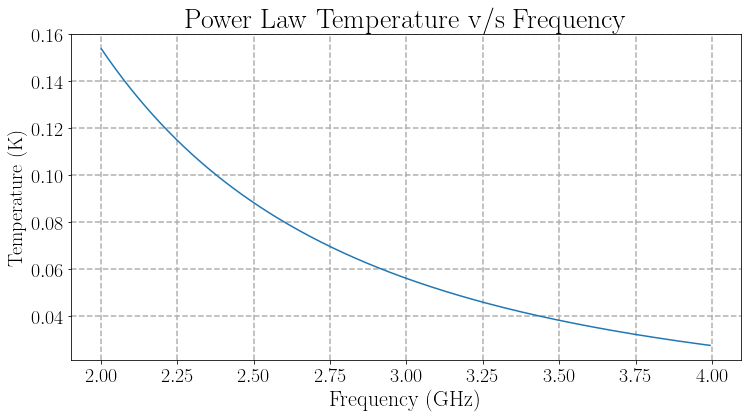

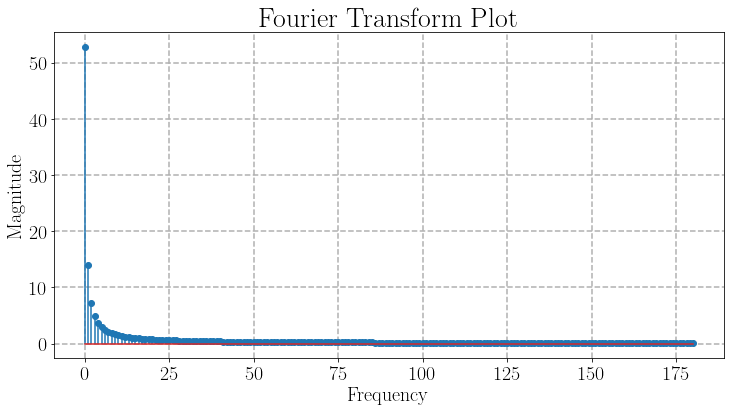

361
(array([0]),)
[0.]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[0.]


In [49]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_pl)
plt.title('Power Law Temperature v/s Frequency',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 22, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

N = len(T_pl)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_pl)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(T_pl))
Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

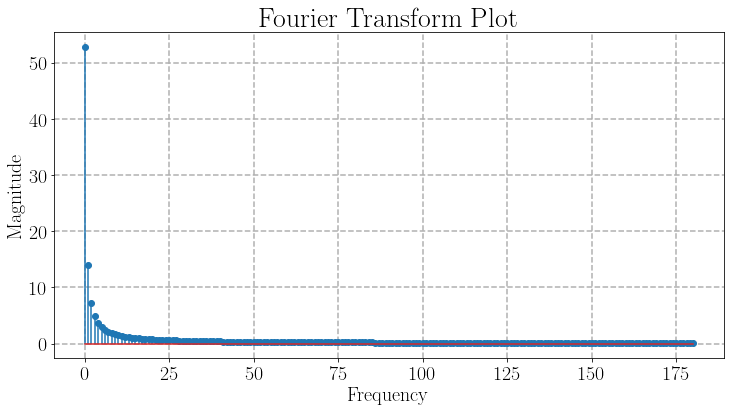

361
(array([0]),)
[0.]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[0.]


/home/ankit-mishra/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/ankit-mishra/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


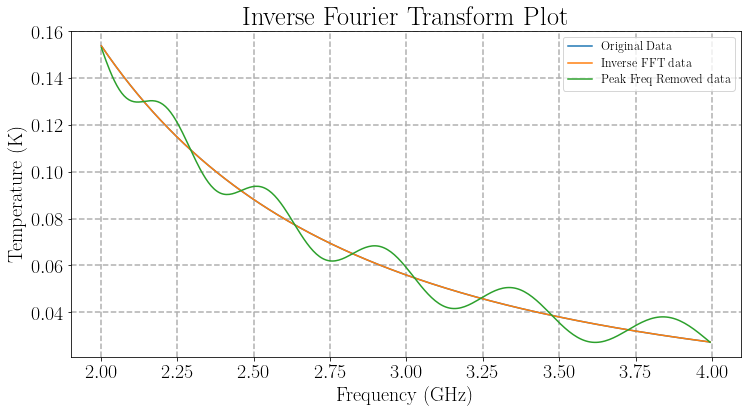

In [15]:
T_combo = []
for i in range(len(freq_24)):
    T_combo.append(T_pl[i] + T_recomb[i])

N = len(T_combo)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_combo)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(T_combo))

Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

Nwaves = []
for val in Freqs:
    Nwaves.append(round(N*val))

FFT_new = np.copy(FFT_vals)    
FFT_new[np.abs(Nwaves) == 5] = 0.0 
IFFT_data = ifft(FFT_vals)
Filt_data = ifft(FFT_new)

plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_combo, label = 'Original Data')
plt.plot(freq_24, IFFT_data, label = 'Inverse FFT data')
plt.plot(freq_24, Filt_data, label = 'Peak Freq Removed data')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.title('Inverse Fourier Transform Plot')
plt.legend(loc = 'upper right', fontsize = 12)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

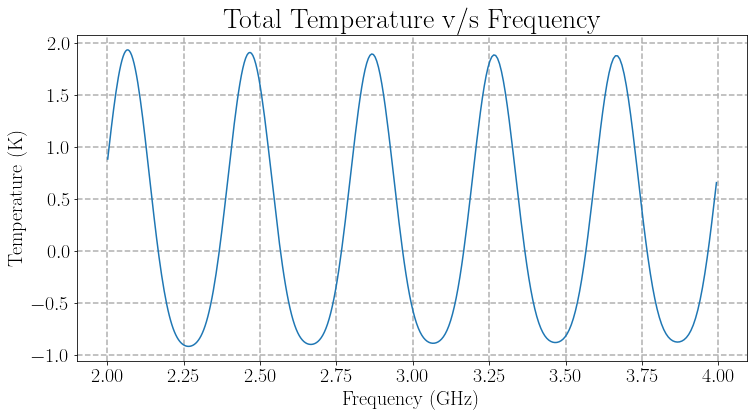

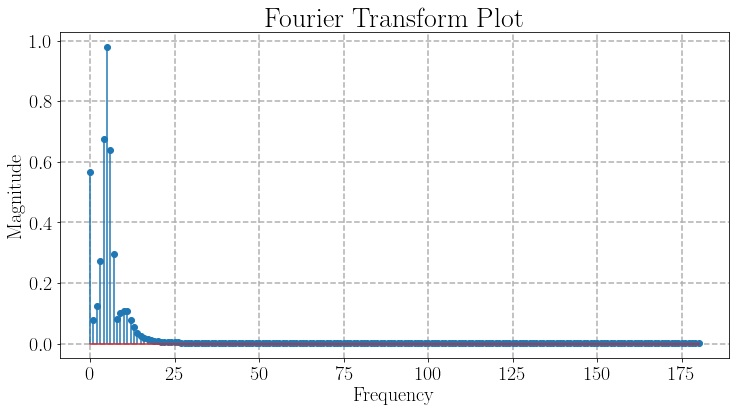

361
(array([5]),)
[0.01385042]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[5.]


/home/ankit-mishra/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/ankit-mishra/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


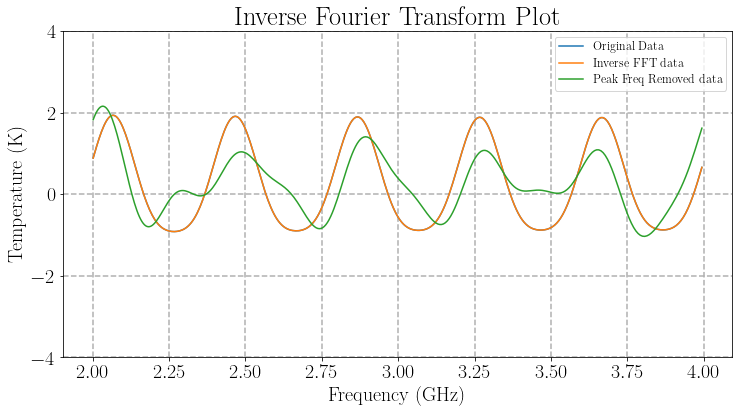

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_total)
plt.title('Total Temperature v/s Frequency',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20,  fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

N = len(T_total)
Freqs = fftfreq(N)

mask = Freqs >= 0
FFT_vals = fft(T_total)
FFT_theo = 2*np.abs(FFT_vals/N)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(T_total))
Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

Nwaves = []
for val in Freqs:
    Nwaves.append(round(N*val))

FFT_new = np.copy(FFT_vals)
FFT_new[np.abs(Nwaves) == 5] = 0.0
IFFT_data = ifft(FFT_vals)
Filt_data = ifft(FFT_new)

plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_total, label = 'Original Data')
plt.plot(freq_24, IFFT_data, label = 'Inverse FFT data')
plt.plot(freq_24, Filt_data, label = 'Peak Freq Removed data')
plt.ylim([-4,4])
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.title('Inverse Fourier Transform Plot')
plt.legend(loc = 'upper right', fontsize = 12)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

# Generate Different Systematics

In [17]:
freq_0 = 2        # Bandwidth GHz

# Declaration of variables of systematics

A = []                         # Amplitude of the systematics
for val in range(0,9):
    A.append((10**(-8))*(10**val))
print('Amplitudes:',len(A))
print(A)

P = list(np.linspace(0,90,10))                        # Phase in degrees
print('Phases:',len(P))
print(P)

nu = list(np.linspace(1/2,10,15))                     # No. of cycles
print('No. of cyles in systematics:',len(nu))
print(nu)

all_Tsys1 = []  # List to store all Tsys1 lists
all_Tsys2 = []  # List to store all Tsys2 lists


for val_A in A:
    for val_P in P:
        for val_nu in nu:
            Tsys1 = []                 # Reset Tsys1 for each iteration
            Tsys2 = []                 # Reset Tsys2 for each iteration           
            
            for val in freq_24:
                Tsys1.append(val_A*np.sin(val_nu*2*np.pi*val/freq_0 + np.pi*val_P/180))
                Tsys2.append(val_A*np.sin(val_nu*2*np.pi*val/freq_0 + np.pi*val_P/180))
                               
            all_Tsys1.append(Tsys1)
            all_Tsys2.append(Tsys2)            

Amplitudes: 9
[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]
Phases: 10
[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]
No. of cyles in systematics: 15
[0.5, 1.1785714285714286, 1.8571428571428572, 2.5357142857142856, 3.2142857142857144, 3.8928571428571432, 4.571428571428571, 5.25, 5.928571428571429, 6.607142857142858, 7.2857142857142865, 7.964285714285714, 8.642857142857142, 9.321428571428571, 10.0]


# Ask the parameters of Tsys1

In [18]:
Tsys1_Para = list(map(float, input("Enter parameters A, P, nu(approx) separated by spaces: ").split()))

nu_list = []
for val in nu:
    nu_list.append(np.abs(val - Tsys1_Para[2]))
Tsys1_Para[2] = (nu[nu_list.index(min(nu_list))])  

print("Entered Parametrs:", Tsys1_Para)  

Enter parameters A, P, nu(approx) separated by spaces: 1 50 7
Entered Parametrs: [1.0, 50.0, 7.2857142857142865]


# Know the indexes for Tsys1

In [19]:
Tsys1_index_A = A.index(Tsys1_Para[0])
Tsys1_index_P = P.index(Tsys1_Para[1])
Tsys1_index_nu = nu.index(Tsys1_Para[2])

print("Amplitude is",Tsys1_Para[0],'and its index is', Tsys1_index_A)
print("Phase is",Tsys1_Para[1],'and its index is', Tsys1_index_P)
print("No of cycles are",Tsys1_Para[2],'and its index is', Tsys1_index_nu)

Tsys1_index = len(P)*len(nu)*Tsys1_index_A + len(nu)*Tsys1_index_P + Tsys1_index_nu  # index of Tsys1 in all_Tsys1

Amplitude is 1.0 and its index is 8
Phase is 50.0 and its index is 5
No of cycles are 7.2857142857142865 and its index is 10


# Ask the parameters of Tsys2

In [20]:
Tsys2_Para = list(map(float, input("Enter Tsys2 parameters A, P, nu(approx) separated by spaces: ").split()))

nu_list = []
for val in nu:
    nu_list.append(np.abs(val - Tsys2_Para[2]))
Tsys2_Para[2] = (nu[nu_list.index(min(nu_list))])  

print("Entered Parametrs:", Tsys2_Para) 

Enter Tsys2 parameters A, P, nu(approx) separated by spaces: 0.001 20 4
Entered Parametrs: [0.001, 20.0, 3.8928571428571432]


# Know the indexes for Tsys2

In [21]:
Tsys2_index_A = A.index(Tsys2_Para[0])
Tsys2_index_P = P.index(Tsys2_Para[1])
Tsys2_index_nu = nu.index(Tsys2_Para[2])

print("Amplitude is",Tsys2_Para[0],'and its index is', Tsys2_index_A)
print("Phase is",Tsys2_Para[1],'and its index is', Tsys2_index_P)
print("No of cycles are",Tsys2_Para[2],'and its index is', Tsys1_index_nu)

Tsys2_index = len(P)*len(nu)*Tsys2_index_A + len(nu)*Tsys2_index_P + Tsys2_index_nu  # index of Tsys1 in all_Tsys1

Amplitude is 0.001 and its index is 5
Phase is 20.0 and its index is 2
No of cycles are 3.8928571428571432 and its index is 10


# Plot Tsys1

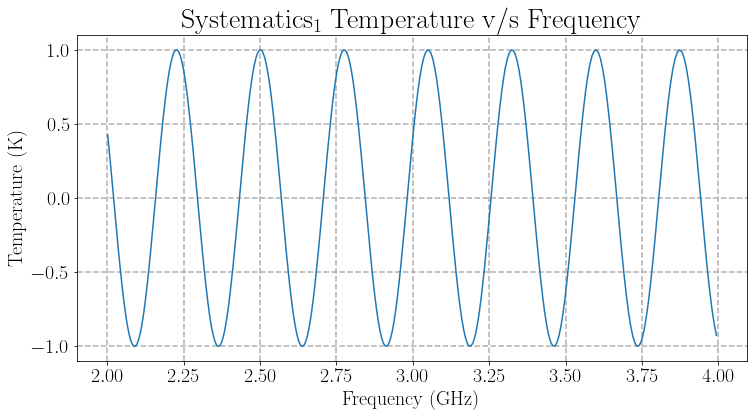

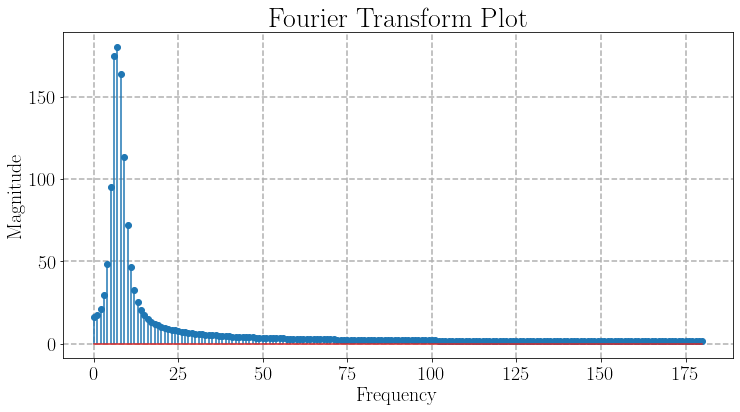

361
(array([7]),)
[0.01939058]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[7.]


In [22]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, all_Tsys1[Tsys1_index])
plt.title('Systematics$_1$ Temperature v/s Frequency ',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
#plt.xlim([2,4])
#plt.ylim([0,5e-7])
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

N = len(all_Tsys1[Tsys1_index])
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(all_Tsys1[Tsys1_index])
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
#plt.stem(fft_theo)
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(all_Tsys1[Tsys1_index]))

Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

# Plot Tsys2

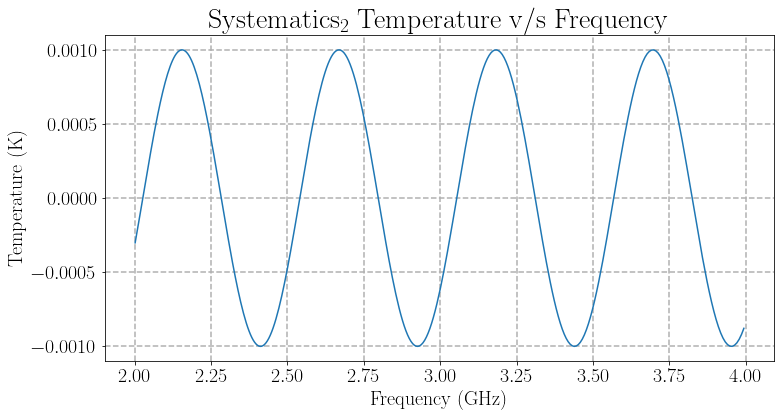

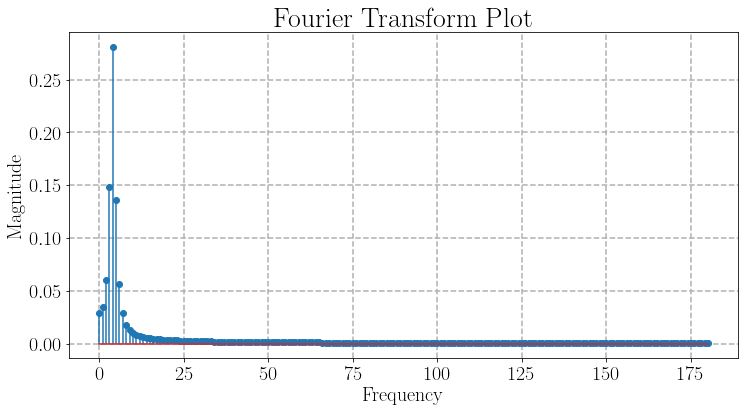

361
(array([4]),)
[0.01108033]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[4.]


In [23]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, all_Tsys2[Tsys2_index])
plt.title('Systematics$_2$ Temperature v/s Frequency ',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

N = len(all_Tsys2[Tsys2_index])
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(all_Tsys2[Tsys2_index])
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(all_Tsys2[Tsys2_index]))

Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

In [24]:
Tsys1 = all_Tsys1[Tsys1_index]
Tsys2 = all_Tsys2[Tsys2_index]

T_total_no_sig = []
T_total_sig = []
T_CMB_sys2 = []
T_sys1_sys2 = []
T_pl_sys2 = []
T_recomb_sys2 = []
T_pl_recomb_sys2 = []


for i in range(len(freq_24)):
    T_total_no_sig.append((T_pl[i] + Tsys1[i] + T_CMB)*Tsys2[i])
    T_total_sig.append((T_pl[i] + T_recomb[i] + Tsys1[i] + T_CMB)*Tsys2[i]) 
    T_CMB_sys2.append(T_CMB*Tsys2[i])
    T_sys1_sys2.append(Tsys1[i]*Tsys2[i])
    T_pl_sys2.append(T_pl[i]*Tsys2[i])
    T_recomb_sys2.append(T_recomb[i]*Tsys2[i])
    T_pl_recomb_sys2.append((T_pl[i] + T_recomb[i])*Tsys2[i])

# Plot of Total Temperature including recombination

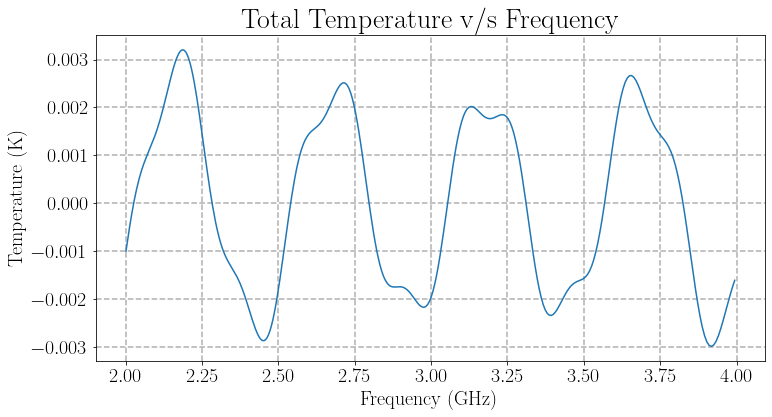

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_total_sig)
plt.title('Total Temperature v/s Frequency',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

# Plot of Total Temperature without recombination

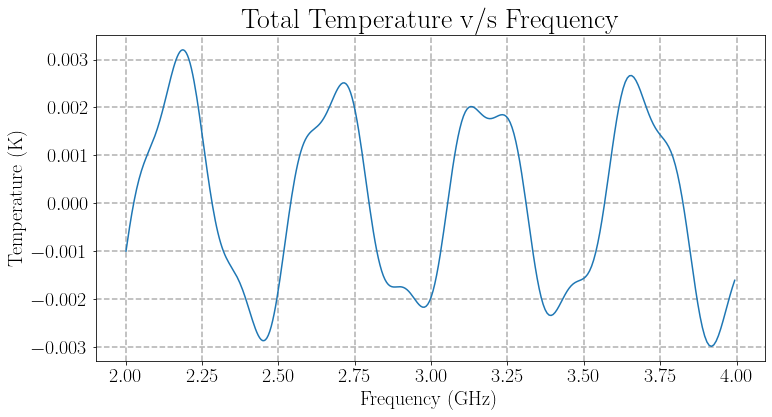

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_total_no_sig)
plt.title('Total Temperature v/s Frequency',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

# Matched Filtering

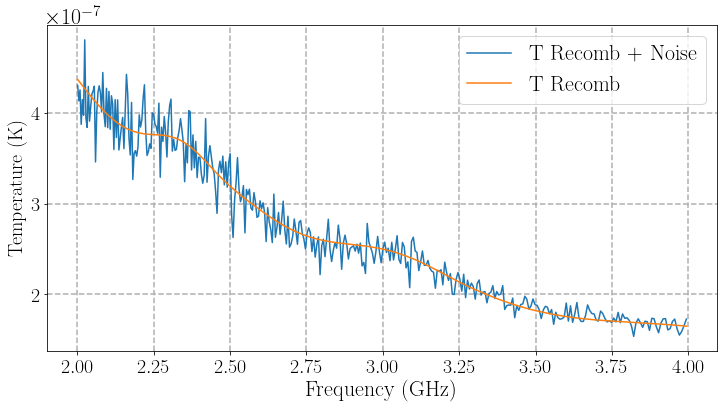

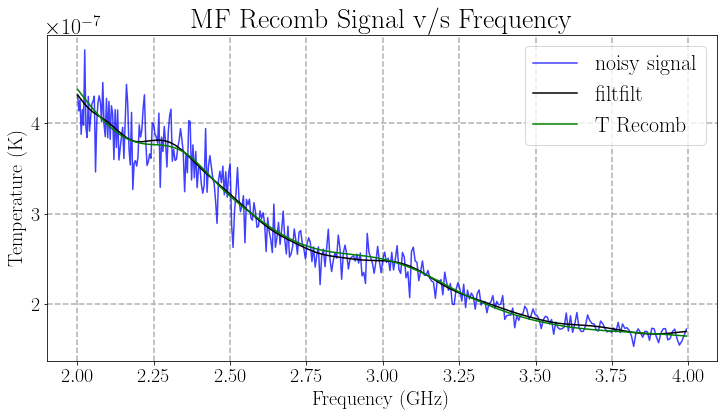

[ 1.         -2.6861574   2.41965511 -0.73016535]
[0.00041655 0.00124964 0.00124964 0.00041655]


In [54]:
t = 1000                                # hours
delta_tau = (freq_24[-1] - freq_24[0])/len(freq_24)
sigma = []

for i in range(len(T_pl)):
    sigma.append(T_pl[i]/(np.sqrt(delta_tau*(10**9)*t*3600)))

Rand_noise = []

for val in sigma:
    Rand_noise.append(np.random.normal(loc=0, scale = val, size=1))
    
T_pl_Rand_noise = []
T_pl_Rand_noise_recomb = []
T_Rand_noise_recomb = []

for i in range(len(T_pl)):  
    T_pl_Rand_noise.append(T_pl[i]+Rand_noise[i])
    T_Rand_noise_recomb.append(Rand_noise[i]+T_recomb[i])
    T_pl_Rand_noise_recomb.append(T_pl[i]+Rand_noise[i]+T_recomb[i])


plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_Rand_noise_recomb,label='T Recomb + Noise')
plt.plot(freq_24, T_recomb,label='T Recomb')
plt.xlabel('Frequency (GHz)',fontsize = 22, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()

import scipy.signal as sp

sig = T_recomb
signoise =  np.array(T_Rand_noise_recomb)
signoise = signoise.reshape((361,))
h = sig[::-1]

b, a = sp.butter(3, 0.05)
y = sp.filtfilt(b, a, signoise)


plt.figure(figsize=(12, 6))
plt.plot(freq_24, signoise, 'b',label='noisy signal',alpha=0.75)
plt.plot(freq_24, y, 'k',label='filtfilt')
plt.plot(freq_24, T_recomb,'g',label='T Recomb')
plt.title('MF Recomb Signal v/s Frequency ',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend(loc='best')
plt.show()

print(a)
print(b)

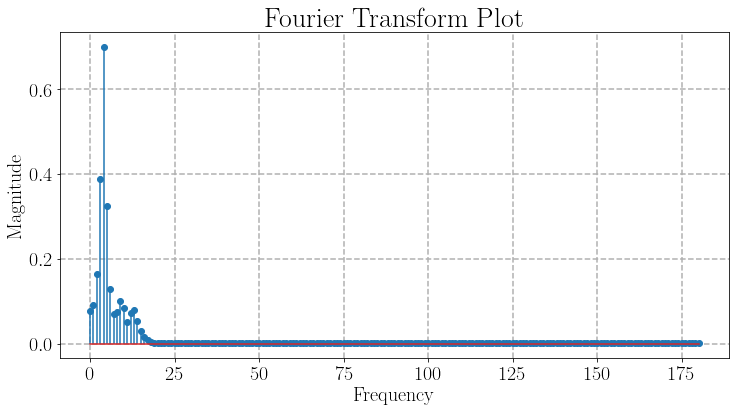

361
(array([4]),)
[0.01108033]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[4.]


/home/ankit-mishra/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/ankit-mishra/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


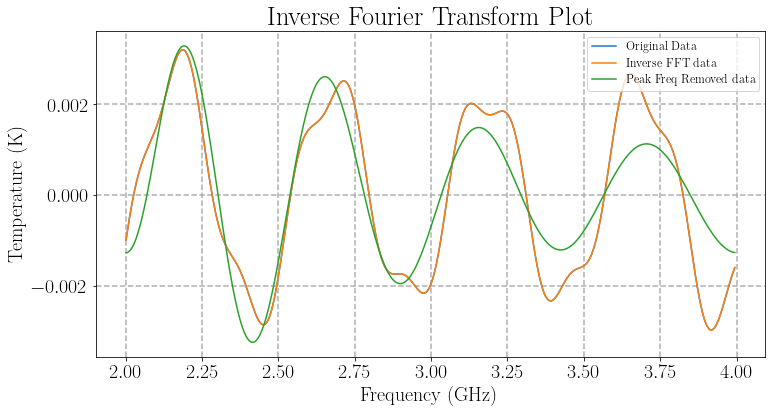

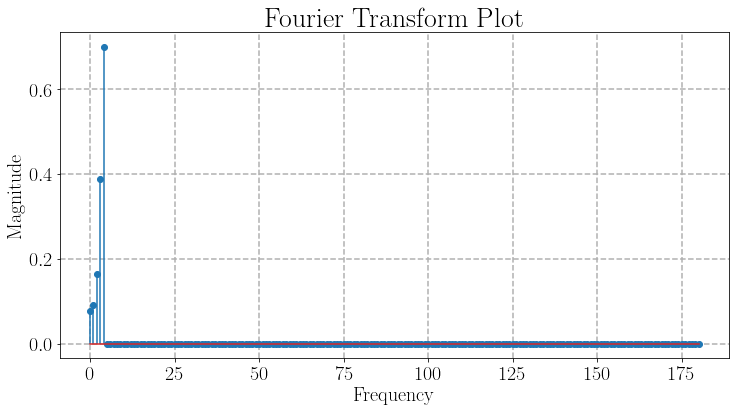

In [28]:
N = len(T_total_sig)
Freqs = fftfreq(N)

mask = Freqs >= 0
FFT_vals = fft(T_total_sig)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]
FFT_vals_T_total_sig = np.copy(FFT_vals)
FFT_masked_T_total_sig = np.copy(FFT_masked)

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(T_total_sig))

Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

Nwaves = []
for val in Freqs:
    Nwaves.append(round(N*val))


FFT_new = np.copy(FFT_vals)

for i in range(5,361): 
    FFT_new[np.abs(Nwaves) == i] = 0.0

IFFT_data_1 = ifft(FFT_vals)
Filt_data_1 = ifft(FFT_new)

plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_total_sig, label = 'Original Data')
plt.plot(freq_24, IFFT_data_1, label = 'Inverse FFT data')
plt.plot(freq_24, Filt_data_1,label = 'Peak Freq Removed data')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.title('Inverse Fourier Transform Plot')
plt.legend(loc = 'upper right', fontsize = 12)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

N = len(Filt_data_1)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(Filt_data_1)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

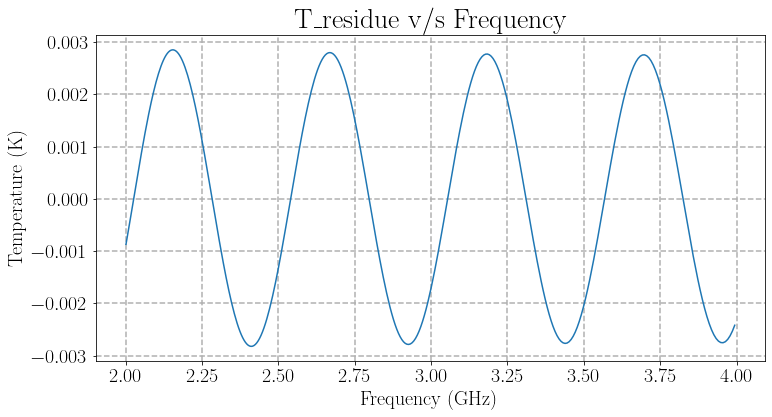

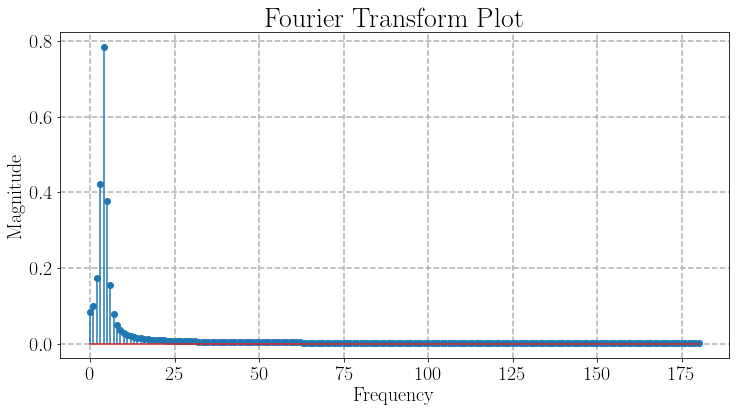

361
(array([4]),)
[0.01108033]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[4.]


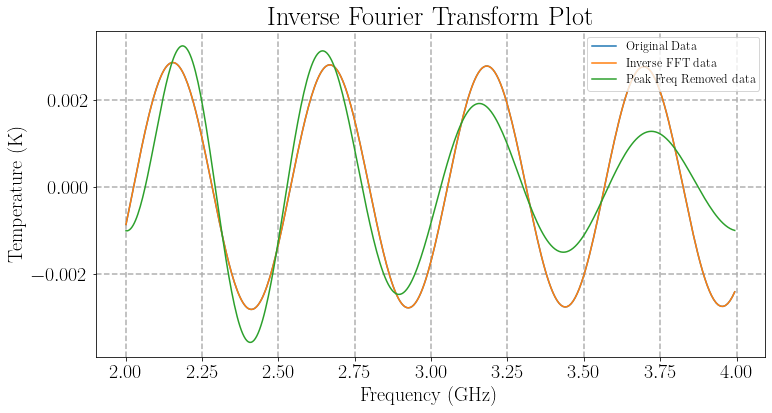

In [29]:
T_residue = []
for i in range(len(freq_24)):
    T_residue.append((T_pl[i] + T_recomb[i] + T_CMB)*all_Tsys2[Tsys2_index][i])

plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_residue)
plt.title('T_residue v/s Frequency',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

N = len(T_residue)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_residue)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(T_residue))

Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

Nwaves = []
for val in Freqs:
    Nwaves.append(round(N*val))

FFT_new = np.copy(FFT_vals)

for i in range(5,361):
    FFT_new[np.abs(Nwaves) == i] = 0.0

IFFT_data = np.real(ifft(FFT_vals))
Filt_data = np.real(ifft(FFT_new))

plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_residue, label = 'Original Data')
plt.plot(freq_24, IFFT_data, label = 'Inverse FFT data')
plt.plot(freq_24, Filt_data, label = 'Peak Freq Removed data')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.title('Inverse Fourier Transform Plot')
plt.legend(loc = 'upper right', fontsize = 12)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

# Fourier Analysis of T_CMB_sys2

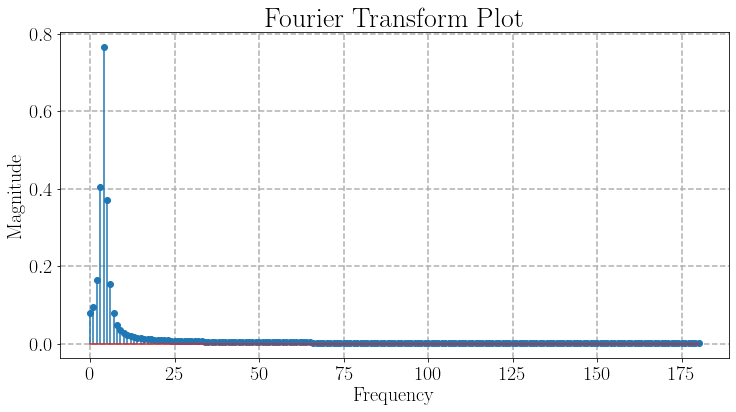

In [30]:
N = len(T_CMB_sys2)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_CMB_sys2)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]
FFT_vals_T_CMB_sys2 = np.copy(FFT_vals)

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

# Fourier Analysis of T_sys1_sys2

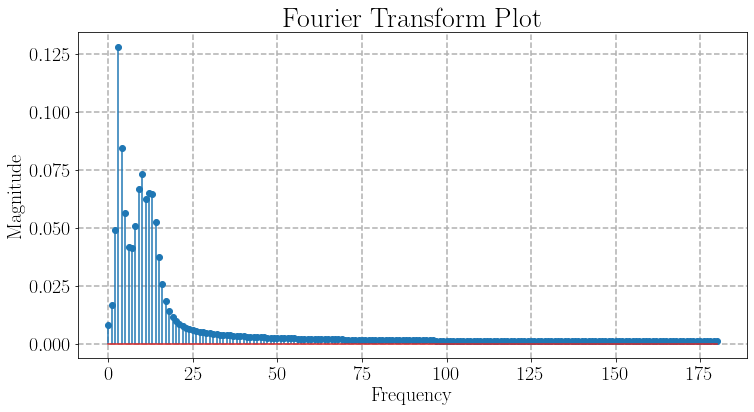

In [64]:
N = len(T_sys1_sys2)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_sys1_sys2)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]
FFT_vals_T_sys1_sys2 = np.copy(FFT_vals)

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

# Fourier Analysis of T_pl_sys2

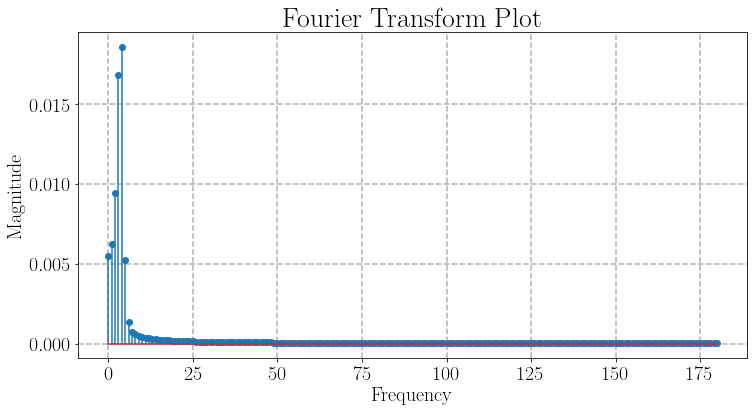

In [32]:
N = len(T_pl_sys2)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_pl_sys2)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]
FFT_vals_T_pl_sys2 = np.copy(FFT_vals)

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

# Fourier Analysis of T_recomb_sys2

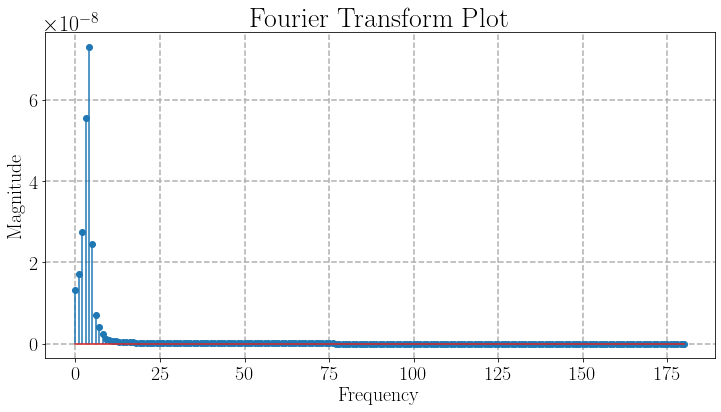

In [33]:
N = len(T_recomb_sys2)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_recomb_sys2)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]
FFT_maksed_T_recomb_sys2 = np.copy(FFT_masked)
FFT_vals_T_recomb_sys2 = np.copy(FFT_vals)

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

# Fourier Analysis of T_pl_recomb_sys2

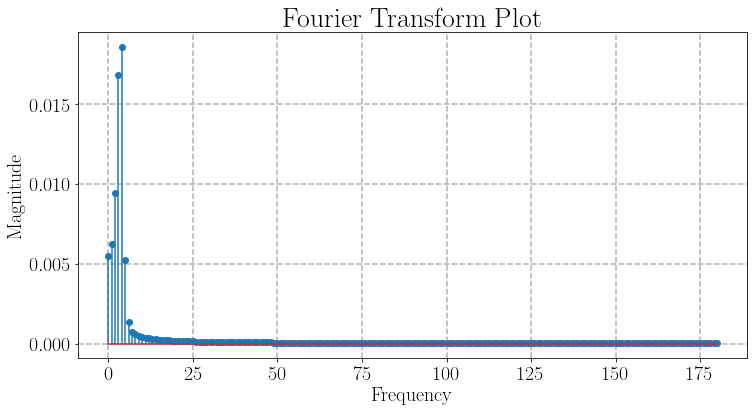

In [34]:
N = len(T_pl_recomb_sys2)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_pl_recomb_sys2)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]
FFT_vals_T_pl_recomb_sys2 = np.copy(FFT_vals)

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

# Fourier Domain Addition

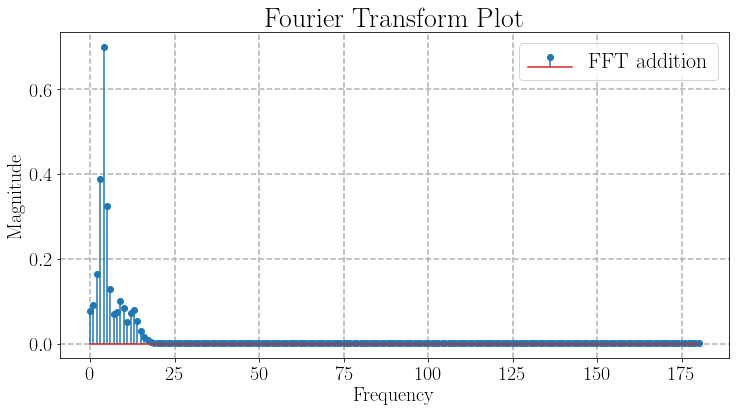

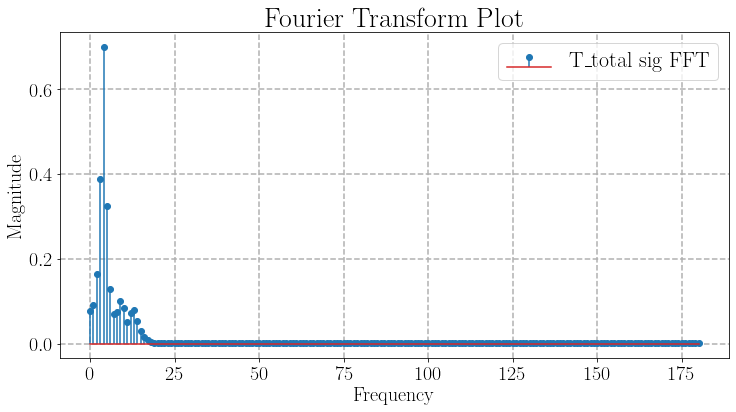

In [35]:
FFT_vals_combine = (FFT_vals_T_CMB_sys2 + FFT_vals_T_sys1_sys2 + FFT_vals_T_pl_sys2 + FFT_vals_T_recomb_sys2)

N = len(T_total_sig)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_theo = 2*np.abs(FFT_vals_combine)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked, label = 'FFT addition' )
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked_T_total_sig, label = 'T_total sig FFT')
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()

# Fourier Domian Reduction

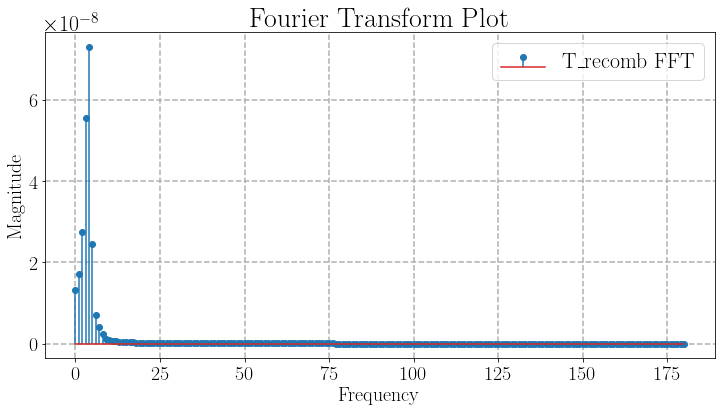

/home/ankit-mishra/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


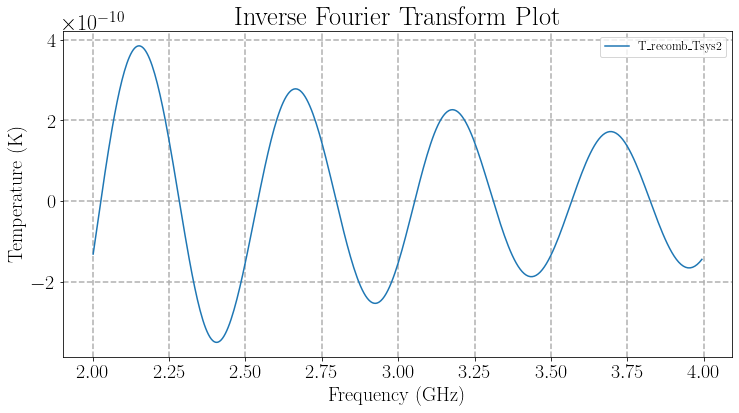

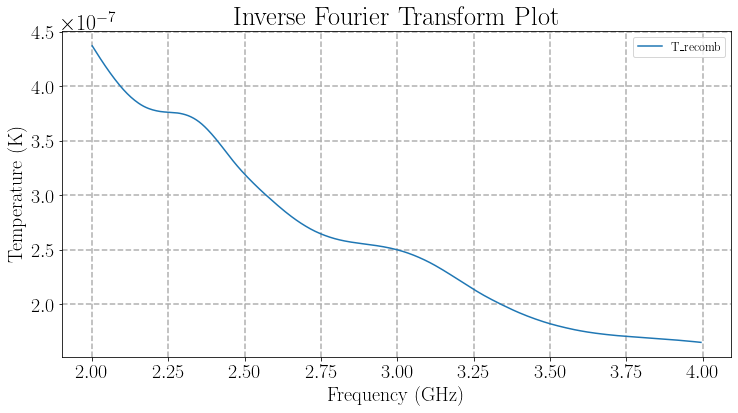

In [56]:
FFT_vals_reduced = FFT_vals_T_total_sig - (FFT_vals_T_CMB_sys2 + FFT_vals_T_sys1_sys2 + FFT_vals_T_pl_sys2)

N = len(T_total_sig)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_theo = 2*np.abs(FFT_vals_reduced)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

IFFT_reduction = (ifft(FFT_vals_reduced))
IFFT_recomb = (ifft(FFT_vals_T_recomb_sys2))

T_recomb_reduced = []
for i in range(len(freq_24)):
    T_recomb_reduced.append(IFFT_recomb[i]/Tsys2[i])
    

plt.figure(figsize=(12, 6))
plt.stem(FFT_maksed_T_recomb_sys2, label = 'T_recomb FFT')
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(freq_24, IFFT_recomb, label = 'T_recomb_Tsys2')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.title('Inverse Fourier Transform Plot')
plt.legend(loc = 'upper right', fontsize = 12)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_recomb, label = 'T_recomb')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.title('Inverse Fourier Transform Plot')
plt.legend(loc = 'upper right', fontsize = 12)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

In [37]:
len(FFT_masked),len(Freq_masked)

(181, 181)

1.1681611963036354e-06 1.0281858277336389 -1.0683829423278444e-08 0.8175421057145913
[[6.47613117e-16 4.16537717e-10 2.43342941e-17 2.87614833e-10]
 [4.16537717e-10 2.69298769e-04 1.58524091e-11 1.84012136e-04]
 [2.43342941e-17 1.58524091e-11 1.38287376e-18 1.04680898e-11]
 [2.87614833e-10 1.84012136e-04 1.04680898e-11 1.60318976e-04]]
Chi-squared: 0.0
Reduced chi-squared: 0.0


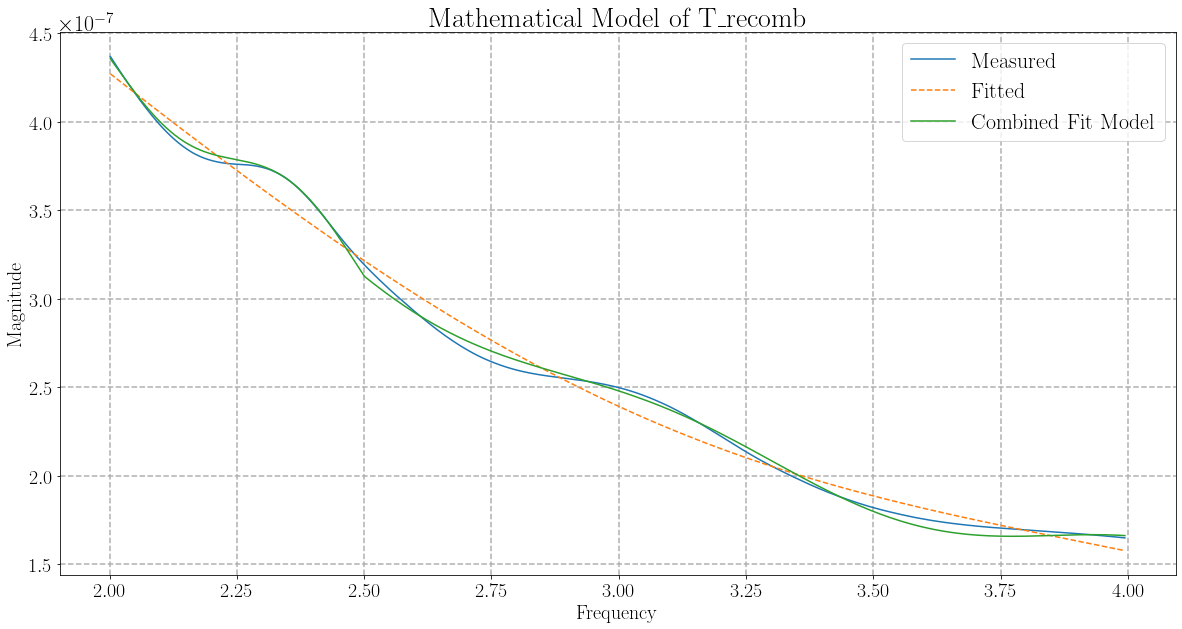

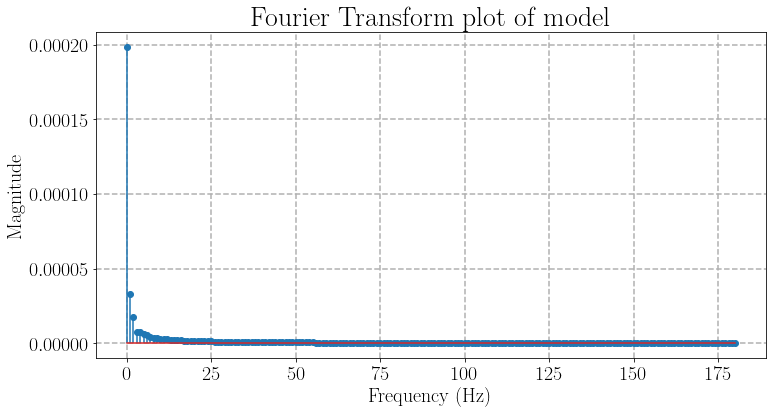

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([0]),)
[0.]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[0.]


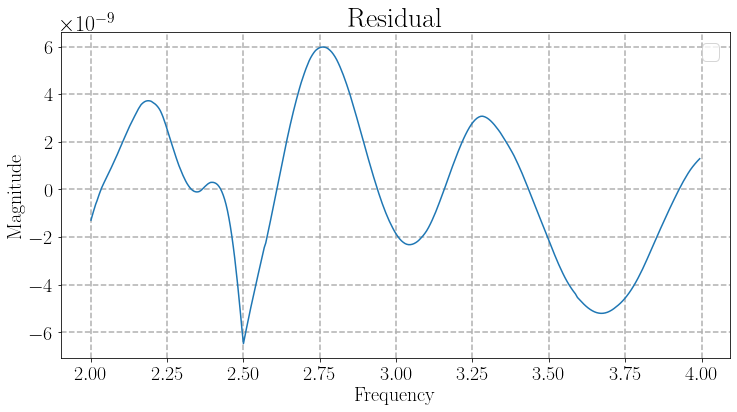

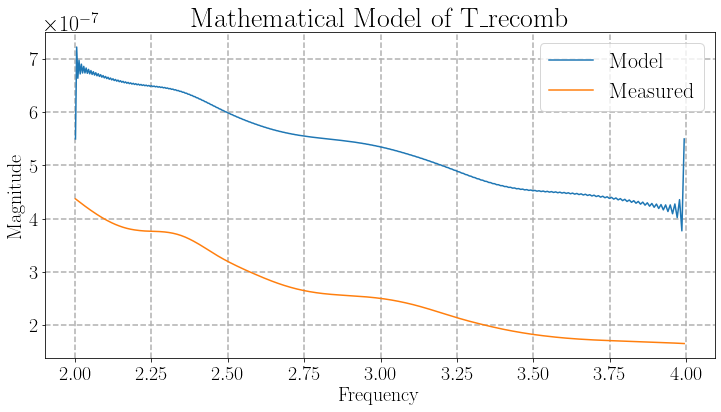

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


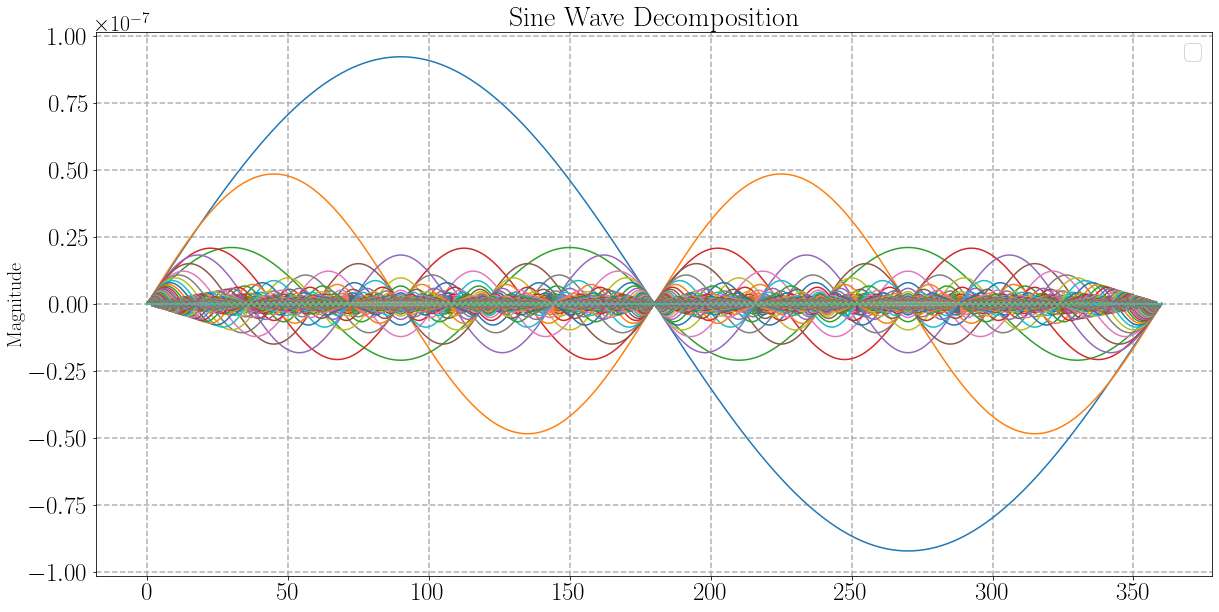

In [43]:
Y_1 = []
Y_2 = []
for val in freq_24:
    Y_1.append(1.1681611963036354e-06*np.exp(-1.0281858277336389*val/freq_0) 
             -1.0683829423278444e-08*np.sin(0.8175421057145913*2*np.pi*val/freq_0)  
             + 1.0683829423278444e-08*np.sin(2*2*np.pi*val/freq_0 + np.pi*(55/180))
             - 1.683829423278444e-08*np.sin(4*2*np.pi*val/freq_0))
    
    Y_2.append(1.1681611963036354e-06*np.exp(-1.0281858277336389*val/freq_0) 
             -1.0683829423278444e-08*np.sin(0.8175421057145913*2*np.pi*val/freq_0)  
             + 1.0683829423278444e-08*np.sin(2*2*np.pi*val/freq_0 + np.pi*(55/180)))

Y = []    
for val in freq_24:
    if val <= 2.5:
        Y.append(1.1681611963036354e-06*np.exp(-1.0281858277336389*val/freq_0) 
             -1.0683829423278444e-08*np.sin(0.8175421057145913*2*np.pi*val/freq_0)  
             + 1.0683829423278444e-08*np.sin(2*2*np.pi*val/freq_0 + np.pi*(55/180))
             - 1.683829423278444e-08*np.sin(4*2*np.pi*val/freq_0))
    else:
        Y.append(1.1681611963036354e-06*np.exp(-1.0281858277336389*val/freq_0) 
             -1.0683829423278444e-08*np.sin(0.8175421057145913*2*np.pi*val/freq_0)  
             + 1.0683829423278444e-08*np.sin(2*2*np.pi*val/freq_0 + np.pi*(55/180)))
    
def func(x, A, B, C, D):
    y = A*np.exp(-B*x/freq_0) + C*np.sin(D*2*np.pi*x/freq_0)
    return y

# Direct least square regression
# the estimated covariance of param in param_cov

(A, B, C, D), param_cov = opt.curve_fit(func, np.array(freq_24), T_recomb)

print(A, B, C, D)
print(param_cov)

Y_fit = func(np.array(freq_24), A, B, C, D)

# Calculate residuals
residuals = Y_fit - func(np.array(freq_24),A, B, C, D)

# Assume constant standard deviation (replace with your estimate if available)
sigma = 1  # Modify this based on your data uncertainty

# Calculate chi-squared
chi_squared = sum((residuals / sigma) ** 2)

# Calculate reduced chi-squared (optional)
reduced_chi_squared = chi_squared / (len(np.array(freq_24)) - 4)

print("Chi-squared:", chi_squared)
print("Reduced chi-squared:", reduced_chi_squared)


N = len(T_recomb)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(T_recomb)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]


plt.figure(figsize=(20, 10))
plt.plot(freq_24,T_recomb, label='Measured')
plt.plot(freq_24,Y_fit, '--', label='Fitted')
plt.plot(freq_24,Y, label='Combined Fit Model')
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Mathematical Model of T_recomb', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency (Hz)', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform plot of model', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

Residual = np.array(Y) - np.array(T_recomb)
plt.figure(figsize=(12, 6))
plt.plot(freq_24,Residual)
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Residual', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()

func = []
const = []

for i in range(len(freq_24)):
    const.append(FFT_masked[0]/N)

func.append(const)

x = np.linspace(0,2*np.pi,N)

for i in range(1,len(FFT_masked)):
        func.append((FFT_masked[i]/N)*np.sin(i*x))
        
T = np.sum(func, axis = 0)   

plt.figure(figsize=(12, 6))
plt.plot(freq_24,T, label='Model')
plt.plot(freq_24,T_recomb, label='Measured')
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Mathematical Model of T_recomb', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1,len(FFT_masked)):
    plt.plot(func[i])
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Sine Wave Decomposition', fontsize = 28)
plt.xticks(fontsize = 25, fontweight='bold')
plt.yticks(fontsize = 25, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()

# Total signal model

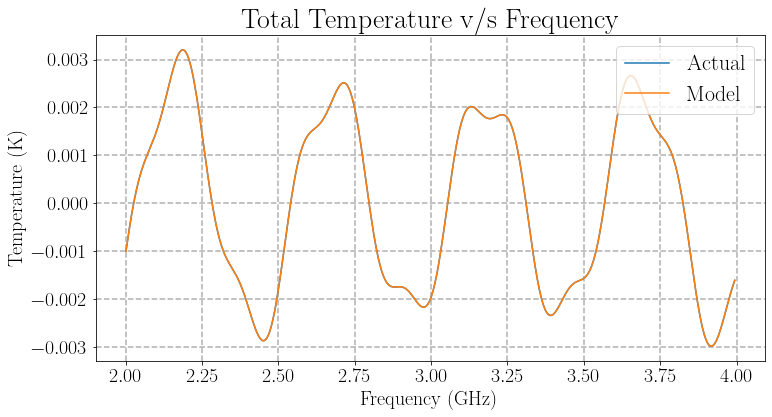

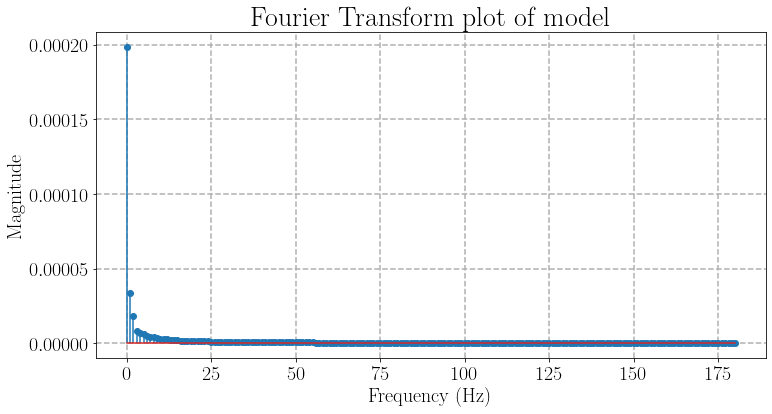

In [48]:
T_total_sig_model = [] 
for i in range(len(freq_24)):
    T_total_sig_model.append((T_pl[i] + Y[i] + Tsys1[i] + T_CMB)*Tsys2[i]) 

plt.figure(figsize=(12, 6))
plt.plot(freq_24, T_total_sig,label='Actual')
plt.plot(freq_24,T_total_sig_model,label='Model')
plt.title('Total Temperature v/s Frequency',fontsize = 28, fontweight='bold')
plt.xlabel('Frequency (GHz)',fontsize = 20, fontweight='bold')
plt.ylabel('Temperature (K)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend(loc='upper right')
plt.show()

N = len(Y)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(Y)
FFT_theo = 2*np.abs(FFT_vals)
FFT_masked = FFT_theo[mask]
Freq_masked = Freqs[mask]

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency (Hz)', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform plot of model', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

/home/ankit-mishra/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


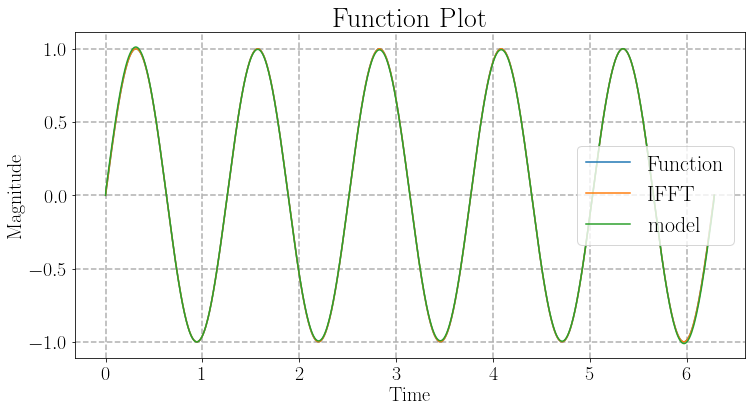

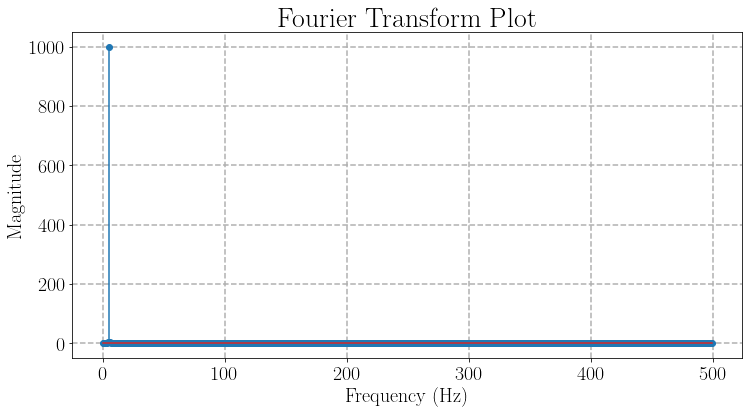

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1000
(array([5]),)
[0.005]
The number of cycles of sine wave in the data corresponding to the max probable period is :
[5.]


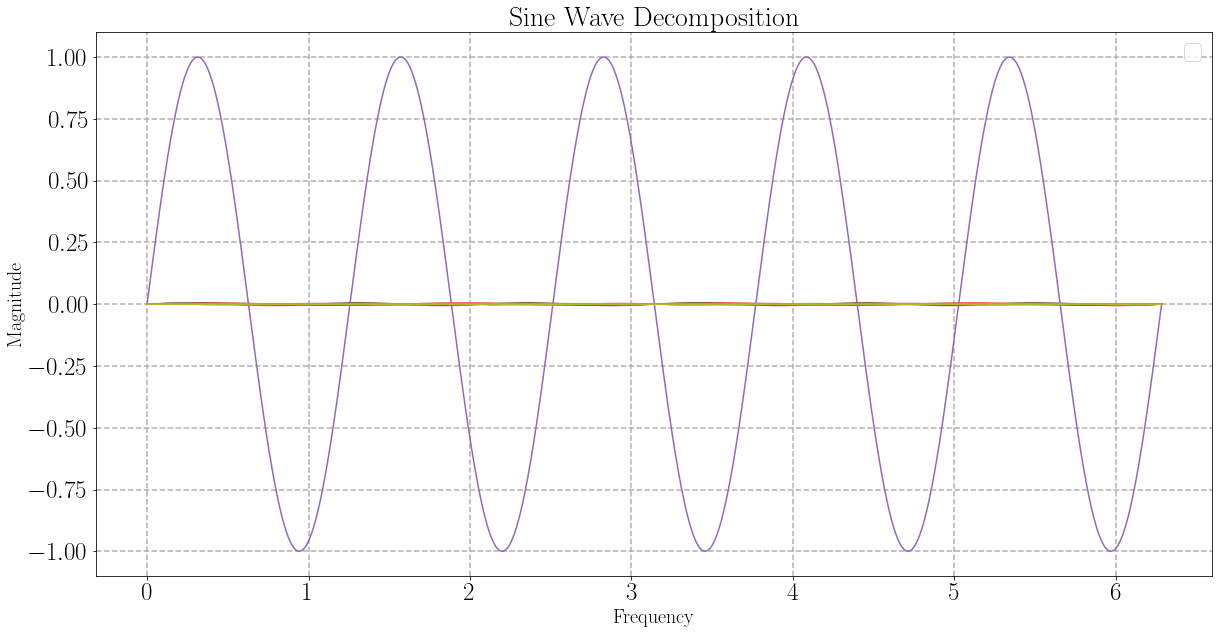

In [47]:
x = np.linspace(0,2*np.pi,1000)
y = np.sin(5*x) 

N = len(y)
Freqs = fftfreq(N)
mask = Freqs >= 0
FFT_vals = fft(y)
FFT_theo = np.abs(FFT_vals)
FFT_masked = 2*FFT_theo[mask]
Freq_masked = Freqs[mask]
IFFT_data = (ifft(FFT_vals))

func = []
const = []

for i in range(len(x)):
    const.append(FFT_masked[0]/N)

func.append(const)

for i in range(1,len(FFT_masked)):
        func.append((FFT_masked[i]/N)*np.sin(i*x))
        
T = np.sum(func, axis = 0) 

plt.figure(figsize=(12, 6))
plt.plot(x,y,label = 'Function')
plt.plot(x,IFFT_data, label = 'IFFT')
plt.plot(x,T, label = 'model')
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Function Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.stem(FFT_masked)
plt.xlabel('Frequency (Hz)', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Fourier Transform Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

print(len(y))

Mag_max_index = np.where(FFT_masked == max(FFT_masked))
print(Mag_max_index)

max_Freq = Freq_masked[Mag_max_index]
print(max_Freq)
N_cycles = N*max_Freq
print('The number of cycles of sine wave in the data corresponding to the max probable period is :')
print(N_cycles)

plt.figure(figsize=(20, 10))
for i in range(1,len(FFT_masked)):
    plt.plot(x,func[i])
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Sine Wave Decomposition', fontsize = 28)
plt.xticks(fontsize = 25, fontweight='bold')
plt.yticks(fontsize = 25, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()

In [69]:
print(FFT_masked)

[5.96744876e-16 9.94804569e+01 1.35641612e+00 7.60374067e-01
 5.40692148e-01 4.22827747e-01 3.48465745e-01 2.97027807e-01
 2.59251938e-01 2.30311770e-01 2.07430830e-01 1.88893149e-01
 1.73578703e-01 1.60724288e-01 1.49791382e-01 1.40388869e-01
 1.32225697e-01 1.25080736e-01 1.18782933e-01 1.13197888e-01
 1.08218534e-01 1.03758533e-01 9.97474969e-02 9.61274856e-02
 9.28503829e-02 8.98759167e-02 8.71701387e-02 8.47042482e-02
 8.24536690e-02 8.03973211e-02 7.85170386e-02 7.67971023e-02
 7.52238608e-02 7.37854221e-02 7.24713996e-02 7.12727034e-02
 7.01813672e-02 6.91904035e-02 6.82936831e-02 6.74858343e-02
 6.67621578e-02 6.61185549e-02 6.55514681e-02 6.50578303e-02
 6.46350225e-02 6.42808391e-02 6.39934590e-02 6.37714219e-02
 6.36136106e-02 6.35192365e-02]


In [60]:
print(T)

[ 1.29609865e-17  4.24713097e-02  8.19472229e-02  1.21210154e-01
  1.60242644e-01  1.99008207e-01  2.37467837e-01  2.75574053e-01
  3.13267334e-01  3.50479182e-01  3.87139854e-01  4.23185916e-01
  4.58563281e-01  4.93224589e-01  5.27123386e-01  5.60209258e-01
  5.92426984e-01  6.23719829e-01  6.54034385e-01  6.83323619e-01
  7.11546307e-01  7.38663639e-01  7.64635632e-01  7.89419855e-01
  8.12973220e-01  8.35255375e-01  8.56231273e-01  8.75871215e-01
  8.94148560e-01  9.11036887e-01  9.26508701e-01  9.40536501e-01
  9.53095375e-01  9.64165195e-01  9.73730917e-01  9.81780881e-01
  9.88304452e-01  9.93290725e-01  9.96729199e-01  9.98611844e-01
  9.98935037e-01  9.97699986e-01  9.94911396e-01  9.90575416e-01
  9.84698357e-01  9.77287084e-01  9.68350731e-01  9.57902440e-01
  9.45959862e-01  9.32544069e-01  9.17677704e-01  9.01383698e-01
  8.83685461e-01  8.64608332e-01  8.44181179e-01  8.22436949e-01
  7.99411761e-01  7.75143195e-01  7.49669002e-01  7.23027129e-01
  6.95256969e-01  6.66400

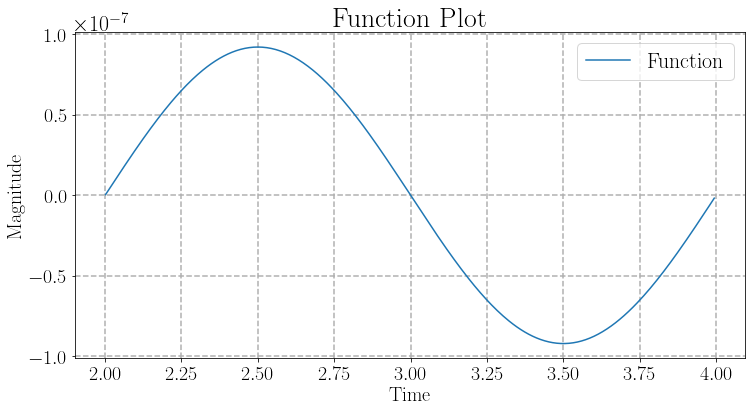

In [21]:
z = ((FFT_masked[1]/N)*np.sin(2*np.pi*1*np.array(freq_24)/freq_0))
plt.figure(figsize=(12, 6))
plt.plot(freq_24,z,label = 'Function')
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 20)
plt.title('Function Plot', fontsize = 28)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.legend()
plt.show()